# postISR on WFS corner sensors using bscDbType: refCat


In [1]:
#from lsst.ts.wep.cwfs.Instrument import Instrument
# del sys.modules['lsst.ts.wep.cwfs.Instrument']

In [93]:
import os 

In [69]:
# to reload WepController after some code editing,
# need to run the code below - 
# it tells python to remove the name binding. 
# Python searches sys.modules to see whether 
# the modules had already been imported,
# and if they had, they are not reloaded 
import sys
del sys.modules['lsst.ts.wep.WepController']
del sys.modules['lsst.ts.wep.ctrlIntf.WEPCalculationFactory']
del sys.modules['lsst.ts.wep.Utility']
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory

# mostly from runCloseLoopPostISR.py 
from lsst.ts.wep.Utility import CamType, FilterType, getModulePath, mapFilterRefToG, DefocalType

### $$ Aside: Remove old database, or use a custom filename for dbFile ... 

Just to be sure, remove the old database, which would still be there if we didn't finish the loop

In [71]:
path_to_ts_wep = '/epyc/users/suberlak/Commissioning/aos/ts_wep/'
bscDataDir = os.path.join(path_to_ts_wep, 'tests/testData')
dbFile = 'bsc.db3'
if dbFile  in os.listdir(bscDataDir):
    os.remove(os.path.join(bscDataDir,dbFile))
    print('Removed old %s file'%dbFile)

Removed old bsc.db3 file


### Set the ra,dec for the GAIA field based on the name 

In [72]:
import sys
sys.path.append('../analysis_tools/')
import analysisTools as at

import os
topDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
closed_loop_input_dir = os.path.join(topDir,'dr2_med_full_2020_24_wide_wfs_1500/input/')
raInDeg, decInDeg = at.getRaDecFromGaiaField('med')

For this field, the raInDeg=233.017, decInDeg=-4.447


### $$ Aside: Manually overwrite default.yaml ...
Need to manually change the setting in `policy/default.yaml` , because there is no way to force `ts_wep` to actually instantiate the `wep_calculator` while using a different settings file ... 

In [73]:
path_to_ts_wep = '/epyc/users/suberlak/Commissioning/aos/ts_wep/'

# what bscDbType do we want to use ? 
bscDbType = 'refCat'

from lsst.ts.wep.ParamReader import ParamReader
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('Before change: ', settingFile.getSetting("bscDbType"))


# In the following we update the setting for bscDbType saving the change in the default.yaml file 
settingFile.updateSetting("bscDbType", bscDbType)
settingFile.saveSetting(filePath=settingFilePath)

# check that the change indeed took place 
settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)
print('After change: ', settingFile.getSetting("bscDbType"))

Before change:  refCat
After change:  refCat


### Initialize wep_calc 

In [74]:
print('Using %s '%closed_loop_input_dir )
# these are basically parts of WEPCalculationFactory.py  calculateWavefrontErrors()
# skipping the ingest and ISR 
wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)
wep_calc.wepCntlr.setPostIsrCcdInputs(os.path.join(closed_loop_input_dir, 'rerun/run1'))
rotAngInDeg = 0.0
wep_calc.setBoresight(raInDeg, decInDeg)
wep_calc.setRotAng(rotAngInDeg)
        
obsIdList = [9006002]


Using /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wide_wfs_1500/input/ 


In [75]:
expWcs=False
settingFile= ParamReader(filePath=settingFilePath)
settingFile.updateSetting("expWcs", expWcs)
settingFile.saveSetting(filePath=settingFilePath)
print('After change: expWcs : ', settingFile.getSetting("expWcs"))

After change: expWcs :  False


In [76]:
neighborStarMap = wep_calc._getTargetStar(obsIdList, defocalState=DefocalType.Intra)
detector_list = list(neighborStarMap)

{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}
FITS standard SkyWcs:
Sky Origin: (231.834036, -5.656310)
Pixel Origin: (1425.74, 1968.79)
Pixel Scale: 0.198493 arcsec/pixel
0     231.776693
1     231.864256
2     231.896777
3     231.928032
4     231.929725
         ...    
62    231.712180
63    231.771236
64    231.847736
65    231.939301
66    231.706997
Name: ra, Length: 67, dtype: float64
0     231.703470
1     231.789893
2     231.820464
3     231.853111
4     231.854023
         ...    
62    231.639054
63    231.697589
64    231.773045
65    231.863161
66    231.635900
Name: ra, Length: 67, dtype: float64
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName': 'S20'}
FITS standard SkyWcs:
Sky Origin: (231.848600, -3.275234)
Pixel Origin: (2040.17, 2095.14)
Pixel Scale: 0.18247 arcsec/pixel
0      231.718212
1      231.769226
2      231.895171
3      231.716517
4      231.768737
          ...    
118    231.869613
119    231.863424
120  

TaskError: Fit failed: median scatter on sky = 15.440 arcsec > 15.000 config.maxScatterArcsec

In [7]:
#def _getTargetStar(self, visitList, defocalState, lowMagnitude=None, highMagnitude=None):
#neighborStarMap = wep_calc._getTargetStar(obsIdList, defocalState=DefocalType.Intra)

### $$ Aside: Check if updating bscDbType gets passed before we initialize source selector ...

In [54]:
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory


wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)


settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = ParamReader(filePath=settingFilePath)

bsdDbType = 'image'
settingFile.updateSetting("bscDbType", bscDbType)



sourSelc = wep_calc.wepCntlr.getSourSelc()
bscDbType = wep_calc._getBscDbType()



/astro/store/epyc/users/suberlak/Commissioning/aos/ts_wep/python/lsst/ts/wep/ParamReader.py:183: UserWarning: Update with the different type of value.
  category=UserWarning)


In [55]:
print(bscDbType) 

BscDbType.LocalDbFromRefCat


No - it doesn't   - that's why whatever setting is in `default.yaml` before `wep_calc` gets instantiated, that's what `bscDbType` will be forever. 

### $$ Aside: Check if updating defaultBscPath gets updated before the  source selector connects to db...

In [58]:
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory


wep_calc = WEPCalculationFactory.getCalculator(CamType.LsstCam, closed_loop_input_dir)
#settingFilePath = os.path.join(path_to_ts_wep, 'policy/default.yaml')
settingFile = wep_calc.getSettingFile()#ParamReader(filePath=settingFilePath)

dbRelativePath = 'tests/testData/bsc_new.db3'
settingFile.updateSetting("defaultBscPath", dbRelativePath)

sourSelc = wep_calc.wepCntlr.getSourSelc()


In [59]:
settingFile.getSetting("defaultBscPath")

'tests/testData/bsc_new.db3'

it does ! So that's the one worth updating so we don't run into trouble 

## Dive into WEPCalculation.py. _getTargetStar

try to **dissect** that issue : 
    
    

In [21]:
# parts of wep_calc._getTargetStar : 
# def _getTargetStar(self, visitList, defocalState, lowMagnitude=None, highMagnitude=None):

from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDetectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType, DefocalType
    
sourSelc = wep_calc.wepCntlr.getSourSelc()
bscDbType = wep_calc._getBscDbType()

dbRelativePath = 'tests/testData/bsc2.db3'
dbAddress = os.path.join(getModulePath(), dbRelativePath)
#Before we start, make sure to delete any old db : 
if os.path.exists(dbAddress):
    os.remove(dbAddress)
sourSelc.connect(dbAddress)

# Do the query
sourSelc.setObsMetaData(wep_calc.raInDeg, wep_calc.decInDeg, wep_calc.rotSkyPos)
camDimOffset = wep_calc.settingFile.getSetting("camDimOffset")

## Now inside SourceSelector.py "getTargetStarFromRefCat": 

In [22]:
from lsst.ts.wep.Utility import mapFilterRefToG, getConfigDir  
from lsst.ts.wep.ctrlIntf.PhosimWcsSol import PhosimWcsSol
# neighborStarMap = sourSelc.getTargetStarFromRefCat(
#     wep_calc._getButlerRootPath(), visitList, defocalState,
#     offset=camDimOffset)[0]

# def getTargetStarFromRefCat(self, butlerRootPath, visitList, defocalState,
#                                 offset=0):
# args passed to the function : 
# here self == sourSelc. 
butlerRootPath = wep_calc._getButlerRootPath()
visitList=obsIdList
defocalState=DefocalType.Intra
offset=camDimOffset

filterType = sourSelc.getFilter()
mappedFilterType = mapFilterRefToG(filterType)


True

In [25]:
# self.camera._wcs.setWcsDataFromIsrDir(mappedFilterType,
#                                                   self.camera.getWfsCcdList(),
#                                                   visitList[0])

if type(sourSelc.camera._wcs) == PhosimWcsSol:
    sourSelc.camera._wcs.setWcsDataFromIsrDir(mappedFilterType,
                                          sourSelc.camera.getWfsCcdList(),
                                          visitList[0])

In [12]:
# sourSelc.db.insertDataFromRefCat(butlerRootPath, sourSelc.settingFile,
#                                  visitList, defocalState,
#                                  mappedFilterType,
#                                  sourSelc.camera, skiprows=1)

### $$ Aside: Inside ctrlIntf/PhosimWcsSol.py : setWcsDataFromIsrDir 

In [69]:
filterType = mappedFilterType
ccdList = sourSelc.camera.getWfsCcdList()
visitNum = visitList[0]


from lsst.daf.persistence import Butler
# def setWcsDataFromIsrDir(self, filterType, ccdList, visitNum):
# here self == sourSelc.camera._wcs.
sourSelc.camera._wcs.butler = Butler(sourSelc.camera._wcs.isrDir)
wcsData = {}

for detector in ccdList:
    abbrevName = abbrevDetectorName(detector)
    raft, sensor = parseAbbrevDetectorName(abbrevName)

    data_id = {'visit': visitNum, 'filter': filterType.toString(),
               'raftName': raft, 'detectorName': sensor}
    print(data_id)

    exp = sourSelc.camera._wcs.butler.get('postISRCCD', **data_id)
    w = exp.getWcs()
    wcsData[detector] = w

sourSelc.camera._wcs.wcsData = wcsData

NameError: name 'visitNum' is not defined

### back to SourceSelector.getTargetStarFromRefCat() 

In [26]:
sourSelc.db.createTable(mappedFilterType)

In [63]:
# sourSelc.db.insertDataFromRefCat(butlerRootPath, sourSelc.settingFile,
#                                      visitList, defocalState,
#                                      mappedFilterType,
#                                      sourSelc.camera, skiprows=1)

### Delve into bsc/LocalDatabaseFromRefCat.py , insertDataFromRefCat

In [27]:
import os
import numpy as np
import pandas as pd
import lsst.daf.persistence as dafPersist
import lsst.geom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
import astropy.units as u
from copy import deepcopy
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.astrom import AstrometryTask
from lsst.afw.image.utils import defineFilter
from lsst.ts.wep.bsc.DonutDetector import DonutDetector
from lsst.ts.wep.bsc.LocalDatabaseFromImage import LocalDatabaseFromImage
from lsst.ts.wep.cwfs.TemplateUtils import createTemplateImage
from lsst.ts.wep.Utility import abbrevDetectorName, parseAbbrevDetectorName


# sourSelc.db.insertDataFromRefCat(butlerRootPath, sourSelc.settingFile,
#                                      visitList, defocalState,
#                                      mappedFilterType,
#                                      sourSelc.camera, skiprows=1)

#  def insertDataFromRefCat(self, butlerRootPath, settingFileInst,
#                             visitList, defocalState,
#                             filterType, camera,
#                             skiprows=1, keepFile=True,
#                             fileOut='foundDonuts.txt'):
# here self == sourSelc.db. 
# parse args 
PRE_TABLE_NAME = "StarTable"
settingFileInst = sourSelc.settingFile

filterType = mappedFilterType
camera = sourSelc.camera
keepFile=True
skiprows=1
fileOut='foundDonuts.txt'

# part of insertDataFromRefCat() : 
# self == sourSelc.db
sourSelc.db.expWcs = settingFileInst.getSetting("expWcs")
centroidTemplateType = settingFileInst.getSetting("centroidTemplateType")
donutImgSize = settingFileInst.getSetting("donutImgSizeInPixel")
overlapDistance = settingFileInst.getSetting("minUnblendedDistance")
maxSensorStars = settingFileInst.getSetting("maxSensorStars")
doDeblending = settingFileInst.getSetting("doDeblending")
blendMagDiff = settingFileInst.getSetting("blendMagDiff")
refCatDir = settingFileInst.getSetting("refCatDir")
pix2arcsec = settingFileInst.getSetting("pixelToArcsec")
refButler = dafPersist.Butler(refCatDir)

sourSelc.db.refObjLoader = LoadIndexedReferenceObjectsTask(butler=refButler)


### Inside LocalDatabaseFromRefCat.py  identifyDonuts()

In [28]:
#delve inside identifyDonuts():
# skyDf = self.identifyDonuts(butlerRootPath, visitList, filterType,
#                                     defocalState, camera, pix2arcsec,
#                                     centroidTemplateType, donutImgSize,
#                                     overlapDistance, doDeblending,
#                                     blendMagDiff, maxSensorStars)

# def identifyDonuts(self, butlerRootPath, visitList, filterType,
#                        defocalState, camera, pix2arcsec,
#                        templateType, donutImgSize, overlapDistance,
#                        doDeblending, blendMagDiffLimit, maxSensorStars=None):
        
        
# here self == sourSelc.db. 
# parse args 
templateType = centroidTemplateType
blendMagDiffLimit = blendMagDiff
maxSensorStars = maxSensorStars
    
# back to function
butler = dafPersist.Butler(butlerRootPath)
sensorList = butler.queryMetadata('postISRCCD', 'detectorName')
visitOn = visitList[0]
full_ref_cat_df = None

## [ Aside : Investigate in detail the loop for one detector: 

In [29]:
# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [30]:
#for detector in camera.getWfsCcdList():
camera.getWfsCcdList()

['R:0,0 S:2,2,A',
 'R:0,4 S:2,0,A',
 'R:4,0 S:0,2,A',
 'R:4,4 S:0,0,A',
 'R:0,0 S:2,2,B',
 'R:0,4 S:2,0,B',
 'R:4,0 S:0,2,B',
 'R:4,4 S:0,0,B']

In [130]:
# it works for `R:0,0 S:2,2,A` - why not for `R:0,4 S:2,0,A` ? 
detector = camera.getWfsCcdList()[1]
#####################
# begin the for loop 
#####################
# for detector in camera.getWfsCcdList():
abbrevName = abbrevDetectorName(detector)
raft, sensor = parseAbbrevDetectorName(abbrevName)
print(raft,sensor)
data_id = {'visit': visitOn, 'filter': filterType.toString(),
                       'raftName': raft, 'detectorName': sensor}
print(data_id)

# TODO: Rename this to reflect this is postISR not raw image.
raw = butler.get('postISRCCD', **data_id)

template = createTemplateImage(defocalState,
                           abbrevName, pix2arcsec,
                           templateType, donutImgSize)

R04 S20
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName': 'S20'}


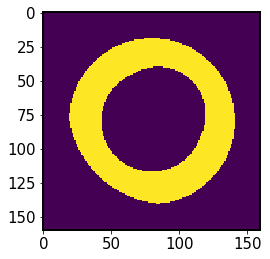

In [131]:
# show the template
%matplotlib inline
plt.imshow(template)

Using the template, find donuts, and create a source catalog: 

In [64]:
from astropy.table import Table
donut_df

,x_center,y_center,blended,blended_with,num_blended_neighbors
0,1253.731329,2674.131264,False,None,0
1,3513.728044,3400.493513,False,None,0
2,832.717506,2132.198347,False,None,0
3,1640.232809,3488.990886,False,None,0
4,3031.023140,3867.357025,False,None,0
5,3437.380601,945.455456,False,None,0
6,3276.601751,1564.241430,False,None,0
7,547.944099,1276.699103,True,[11],1
8,1448.308134,1120.313876,False,None,0
9,181.376518,244.973684,False,None,0


In [132]:
donut_detect = DonutDetector(template)
# min_overlap_distance = 10. # Use for detecting for ref_cat matching
donut_df_len = 0
image_thresh = None
while donut_df_len < 15:
    donut_df, image_thresh = donut_detect.detectDonuts(
        raw, overlapDistance, image_thresh)
    image_thresh = image_thresh*.75
    donut_df_len = len(donut_df)
donut_df.to_csv('source_donut_df_%s.csv' % sensor)
# self == sourSelc.db. 
source_cat = sourSelc.db.makeSourceCat(donut_df)

Show the sources on top of the postISR image for that detector:

Text(0, 0.5, 'y [px]')

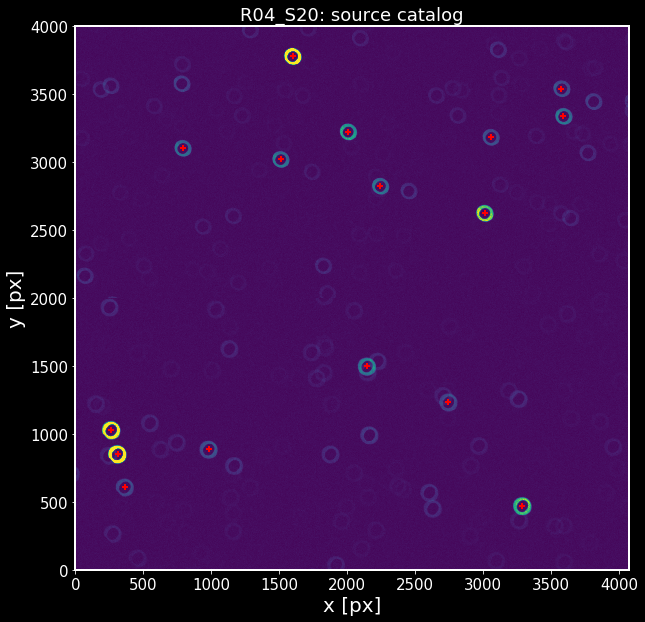

In [146]:
plt.style.use('dark_background')
sc = source_cat.asAstropy()
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(raw.image.array, origin='lower',vmax=1200)
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(sc['slot_Centroid_x'],sc['slot_Centroid_y'] ,**args)
ax.set_title('%s_%s'%(raft,sensor)+': source catalog')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

In [147]:
wcs_solver_result, new_wcs = sourSelc.db.solveWCS(raw, source_cat)

In [78]:
new_wcs

FITS standard SkyWcs:
Sky Origin: (234.193573, -3.256057)
Pixel Origin: (2150.85, 2031.1)
Pixel Scale: 0.214718 arcsec/pixel

In [148]:
wcs_table = wcs_solver_result.getDict()['refCat'].asAstropy()

In [149]:
mag = -2.5*np.log10(wcs_table['phot_g_mean_flux']*1e-9) + 8.9

(array([  6.,   5.,  10.,  20.,  35.,  46.,  74.,  88., 109., 136.]),
 array([13.08956781, 13.90779924, 14.72603066, 15.54426208, 16.3624935 ,
        17.18072492, 17.99895634, 18.81718776, 19.63541918, 20.4536506 ,
        21.27188202]),
 <a list of 10 Patch objects>)

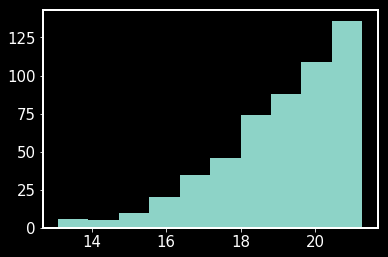

In [150]:
plt.hist(mag)

Plot the reference catalog on top of hte postISR image : 

Text(0, 0.5, 'y [px]')

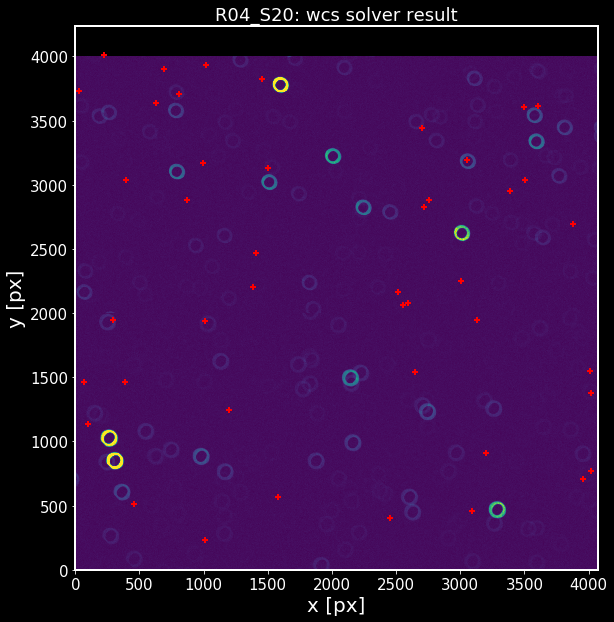

In [152]:
m1 = mag < 17
m2= (wcs_table['centroid_x'] > 0)*(wcs_table['centroid_x'] < 4028)
m3= (wcs_table['centroid_y'] > 0)*(wcs_table['centroid_y'] < 4028)
m = m1 * m2 * m3 
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(raw.image.array, origin='lower',vmax=1200)
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(wcs_table['centroid_x'][m],wcs_table['centroid_y'][m] ,**args)
ax.set_title('%s_%s'%(raft,sensor)+': wcs solver result')
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

In [58]:
sourceCat = source_cat

exposure = deepcopy(raw)

astromConfig = AstrometryTask.ConfigClass()

magLimit = MagnitudeLimit()
magLimit.minimum = 8
magLimit.maximum = 16
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_rp_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 2.99
astromConfig.matcher.maxOffsetPix = 40
astromConfig.wcsFitter.order = 3
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 16

# this is a bit sleazy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now
referenceFilterName = 'phot_rp_mean'
defineFilter(referenceFilterName, 656.28)
referenceFilter = afwImage.filter.Filter(referenceFilterName)
exposure.setFilter(referenceFilter)

sourceSchema = sourceCat.getSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=sourSelc.db.refObjLoader, schema=sourceSchema,)


In [59]:
results = solver.run(sourceCat=sourceCat, exposure=exposure,)

In [68]:
#results

## End of Aside ]

## Big for loop of identifyDonuts() : 

In [42]:
for detector in camera.getWfsCcdList():
    abbrevName = abbrevDetectorName(detector)
    raft, sensor = parseAbbrevDetectorName(abbrevName)
    print(raft,sensor)
    data_id = {'visit': visitOn, 'filter': filterType.toString(),
                           'raftName': raft, 'detectorName': sensor}
    print(data_id)

    # TODO: Rename this to reflect this is postISR not raw image.
    raw = butler.get('postISRCCD', **data_id)

    template = createTemplateImage(defocalState,
                               abbrevName, pix2arcsec,
                               templateType, donutImgSize)

    donut_detect = DonutDetector(template)
    # min_overlap_distance = 10. # Use for detecting for ref_cat matching
    donut_df = donut_detect.detectDonuts(raw, overlapDistance)
    source_cat = sourSelc.db.makeSourceCat(donut_df)


    wcs_solver_result, new_wcs = sourSelc.db.solveWCS(raw, source_cat)

    # Update WCS if using exposure WCS for source selection
    if sourSelc.db.expWcs is True:
        print('\nUpdating exposure WCS for detector %s'%detector)
        old_wcs = camera._wcs.wcsData[detector]
        print('Old WCS', old_wcs)
        print('New WCS', new_wcs)
        camera._wcs.wcsData[detector] = new_wcs

    ref_cat = wcs_solver_result.refCat
    ref_cat_df = ref_cat.asAstropy().to_pandas()
    x_lim, y_lim = list(raw.getDimensions())
    ref_cat_df = ref_cat_df.query(str('centroid_x < %i and centroid_y < %i and ' %
                                      (x_lim - donutImgSize, y_lim - donutImgSize) +
                                      'centroid_x > %i and centroid_y > %i' %
                                      (donutImgSize, donutImgSize)))


    ranked_ref_cat_df = ref_cat_df.sort_values(['phot_g_mean_flux'],
                                               ascending=False)
    ranked_ref_cat_df = ranked_ref_cat_df.reset_index(drop=True)
    ranked_ref_cat_df = donut_detect.labelUnblended(ranked_ref_cat_df,
                                                    overlapDistance,
                                                    'centroid_x',
                                                    'centroid_y')

    # Convert nJy to mags
    mag_list = (ranked_ref_cat_df['phot_g_mean_flux'].values * u.nJy).to(u.ABmag)
    ranked_ref_cat_df['mag'] = np.array(mag_list)


    if doDeblending is False:
        ranked_ref_cat_df = ranked_ref_cat_df.query('blended == False').reset_index(drop=True)
    else:
        single_blends_df = ranked_ref_cat_df.query('num_blended_neighbors == 1')
        new_df = pd.DataFrame(ranked_ref_cat_df.query('blended == False'))
        keep_sys_index = []
        for keep_sys_on in single_blends_df.index:
            blend_index = ranked_ref_cat_df.iloc[keep_sys_on]['blended_with'][0]
            mag_keep = ranked_ref_cat_df.iloc[keep_sys_on]['mag']
            mag_blend = ranked_ref_cat_df.iloc[blend_index]['mag']
            blend_mag_diff = mag_blend - mag_keep
            if np.abs(blend_mag_diff) > blendMagDiffLimit:
                keep_sys_index.append(keep_sys_on)
        if len(keep_sys_index) > 0:
            new_df = pd.concat([new_df, ranked_ref_cat_df.iloc[keep_sys_index]])
        ranked_ref_cat_df = new_df.reset_index(drop=True)


    ranked_ref_cat_df['ra'] = np.degrees(ranked_ref_cat_df['coord_ra'])
    ranked_ref_cat_df['dec'] = np.degrees(ranked_ref_cat_df['coord_dec'])
    ranked_ref_cat_df['raft'] = raft
    ranked_ref_cat_df['sensor'] = sensor

    # Make coordinate change appropriate to sourProc.dmXY2CamXY
    # FIXME: This is a temporary workaround
    if sourSelc.db.expWcs is False:
        # Transpose because wepcntl. _transImgDmCoorToCamCoor
        dimY, dimX = list(raw.getDimensions())
        pixelCamX = ranked_ref_cat_df['centroid_x'].values
        pixelCamY = dimX - ranked_ref_cat_df['centroid_y'].values
        ranked_ref_cat_df['x_center'] = pixelCamX
        ranked_ref_cat_df['y_center'] = pixelCamY
    else:
        ranked_ref_cat_df['x_center'] = ranked_ref_cat_df['centroid_x']
        ranked_ref_cat_df['y_center'] = ranked_ref_cat_df['centroid_y']

    ra, dec = camera._wcs.raDecFromPixelCoords(
        ranked_ref_cat_df['x_center'].values,
        ranked_ref_cat_df['y_center'].values,
        # pixelCamX, pixelCamY,
        detector, epoch=2000.0, includeDistortion=True)

    ra_before = np.copy(ranked_ref_cat_df['ra'])
    ra_after = np.copy(ra)
    ranked_ref_cat_df['ra'] = ra
    ranked_ref_cat_df['dec'] = dec
    print('std(ra_after-ra_before)=',np.std(ra_after-ra_before))
    print('median(ra_after-ra_before)=',np.median(ra_after-ra_before))


    if full_ref_cat_df is None:
        full_ref_cat_df = ranked_ref_cat_df.copy(deep=True)
    else:
        full_ref_cat_df = full_ref_cat_df.append(
            ranked_ref_cat_df)

full_ref_cat_df = full_ref_cat_df.reset_index(drop=True)

# TODO: Comment out when not debugging
full_ref_cat_df.to_csv('image_donut_df.csv')

R00 S22
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}

Updating exposure WCS for detector R:0,0 S:2,2,A
Old WCS FITS standard SkyWcs:
Sky Origin: (231.817044, -5.638935)
Pixel Origin: (1735.38, 1661.5)
Pixel Scale: 0.199123 arcsec/pixel
New WCS FITS standard SkyWcs:
Sky Origin: (231.817044, -5.638935)
Pixel Origin: (1735.38, 1661.5)
Pixel Scale: 0.199123 arcsec/pixel
std(ra_after-ra_before)= 9.944791368561458e-07
median(ra_after-ra_before)= -2.0847264181611536e-07
R04 S20
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName': 'S20'}


RuntimeError: Unable to match sources

std(ra_after-ra_before)= 0.0
median(ra_after-ra_before)= 0.0


In [16]:
sourSelc.db.createTable(mappedFilterType)

In [65]:
# sourSelc.db.insertDataFromRefCat(butlerRootPath, sourSelc.settingFile,
#                              visitList, defocalState,
#                              mappedFilterType, wavefrontSensors,
#                              sourSelc.camera, skiprows=1)

**dissect** insertDataFromRefCat:

In [18]:
# Now we delve into 
# bsc/LocalDatabaseFromRefCat.py: 

# sourSelc.db.insertDataFromRefCat(butlerRootPath, sourSelc.settingFile,
#                              visitList, defocalState,
#                              mappedFilterType, wavefrontSensors,
#                              sourSelc.camera, skiprows=1)


import os
import numpy as np
import pandas as pd
import lsst.daf.persistence as dafPersist
import lsst.geom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
import astropy.units as u
from copy import deepcopy
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.astrom import AstrometryTask
from lsst.afw.image.utils import defineFilter
from lsst.ts.wep.bsc.DonutDetector import DonutDetector
from lsst.ts.wep.bsc.LocalDatabaseFromImage import LocalDatabaseFromImage
from lsst.ts.wep.cwfs.TemplateUtils import createTemplateImage

In [19]:
# def insertDataFromRefCat(self, butlerRootPath, settingFileInst,
#                     visitList, defocalState,
#                     filterType, wavefrontSensors, camera,
#                     skiprows=1, keepFile=True,
#                     fileOut='foundDonuts.txt'):

settingFileInst = sourSelc.settingFile
filterType = mappedFilterType
camera = sourSelc.camera
keepFile=True
skiprows=1
fileOut='foundDonuts.txt'
centroidTemplateType = settingFileInst.getSetting("centroidTemplateType")
donutImgSize = settingFileInst.getSetting("donutImgSizeInPixel")
overlapDistance = settingFileInst.getSetting("minUnblendedDistance")
maxSensorStars = settingFileInst.getSetting("maxSensorStars")
doDeblending = settingFileInst.getSetting("doDeblending")
blendMagDiff = settingFileInst.getSetting("blendMagDiff")
refCatDir = settingFileInst.getSetting("refCatDir")
refButler = dafPersist.Butler(refCatDir)
sourSelc.db.refObjLoader = LoadIndexedReferenceObjectsTask(butler=refButler)

In [20]:
# skyDf = self.identifyDonuts(butlerRootPath, visitList, filterType,
#                                     defocalState, wavefrontSensors, camera,
#                                     centroidTemplateType, donutImgSize,
#                                     overlapDistance, doDeblending,
#                                     blendMagDiff, maxSensorStars)

# self here is sourSelc.db.

#  def identifyDonuts(self, butlerRootPath, visitList, filterType,
#                        defocalState, wavefrontSensors, camera,
#                        templateType, donutImgSize, overlapDistance,
#                        doDeblending, blendMagDiffLimit, maxSensorStars=None):
templateType =centroidTemplateType
blendMagDiffLimit = blendMagDiff 

butler = dafPersist.Butler(butlerRootPath)
sensorList = butler.queryMetadata('postISRCCD', 'detectorName')
visitOn = visitList[0]
full_ref_cat_df = None

In [21]:
wavefrontSensors.items()

dict_items([('R:0,0 S:2,2,A', [(231.87135397625707, -5.707769425551942), (231.762264618411, -5.705774347880815), (231.86971529042452, -5.48356209643951), (231.7606527621133, -5.481586171800562)]), ('R:0,4 S:2,0,A', [(231.7422974655838, -3.2603629290009493), (231.74149580617134, -3.150417973717412), (231.9635706272216, -3.263959981059612), (231.9627097279498, -3.1539970581502503)]), ('R:4,0 S:0,2,A', [(234.29745187539334, -5.631334970431802), (234.29852051229437, -5.741327569889202), (234.07487288827352, -5.62872628985352), (234.07591737990165, -5.738750379840077)]), ('R:4,4 S:0,0,A', [(234.15835810609644, -3.185958931817012), (234.267187794668, -3.18754997059271), (234.1612844562466, -3.4097803528227586), (234.27017051835637, -3.411338790749346)]), ('R:0,0 S:2,2,B', [(231.98078422734733, -5.709689111174835), (231.8716525338712, -5.707723063287425), (231.9791269527977, -5.485465039133161), (231.87002199413243, -5.483515806186849)]), ('R:0,4 S:2,0,B', [(231.7430766320474, -3.370372919837

In [22]:
detector = 'R:0,0 S:2,2,A'
wavefrontSensor = wavefrontSensors[detector]
#for detector, wavefrontSensor in wavefrontSensors.items():
raftStr, sensorStr = detector.split(' ')
raftDigits = raftStr.split(':')[1].split(',')
raft = 'R%s%s' % (raftDigits[0], raftDigits[1])
sensorDigits = sensorStr.split(':')[1].split(',')
sensor = 'S%s%s' % (sensorDigits[0], sensorDigits[1])


In [23]:
data_id = {'visit': visitOn, 'filter': filterType.toString(),
                       'raftName': raft, 'detectorName': sensor}
print(data_id)

{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22'}


In [24]:
# TODO: Rename this to reflect this is postISR not raw image.
raw = butler.get('postISRCCD', **data_id)

In [25]:
template = createTemplateImage(defocalState,
                               detector, [[2000., 2000.]],
                               templateType, donutImgSize)

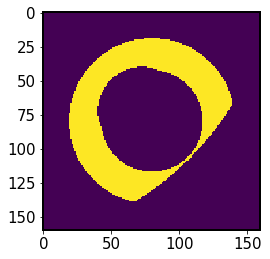

In [57]:
plt.imshow(template)

In [26]:
donut_detect = DonutDetector(template)

In [27]:
# min_overlap_distance = 10. # Use for detecting for ref_cat matching
donut_df = donut_detect.detectDonuts(raw, overlapDistance)

In [48]:
donut_df

,x_center,y_center,blended,blended_with,num_blended_neighbors
0,1944.494317,2073.844420,True,"[467, 687, 878, 989, 994, 1014, 1082, 1254, 12...",10
1,4002.959193,1762.246599,True,"[4, 262, 411, 506, 726]",5
2,2595.801600,1498.059200,True,[309],1
3,1739.168721,1048.537250,True,[1081],1
4,3954.223292,1817.792068,True,"[1, 120, 262, 404, 411, 448, 636, 754, 1275]",9
...,...,...,...,...,...
1342,2693.200000,3074.200000,True,"[346, 447, 515, 526, 535, 566, 643, 651, 693, ...",29
1343,2738.000000,3132.200000,True,"[346, 435, 447, 515, 526, 535, 566, 643, 693, ...",34
1344,718.666667,997.333333,True,"[59, 420, 525, 533, 565, 621, 691, 826, 892, 9...",12
1345,135.800000,1297.800000,True,"[461, 829, 999, 1209, 1265, 1267]",6


In [28]:
source_cat = sourSelc.db.makeSourceCat(donut_df)

In [29]:
np.sum(np.isnan(source_cat['coord_ra']))

1347

In [30]:
s = source_cat.asAstropy()

Read in the postISR image :

In [35]:
post = butler.get('postISRCCD', **data_id) 

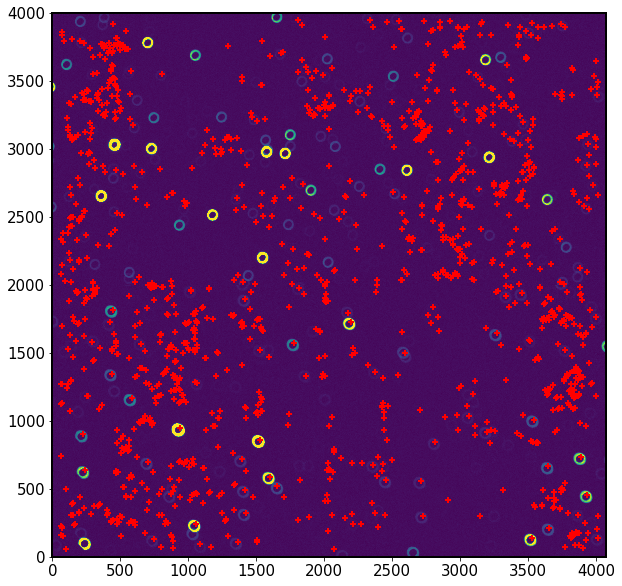

In [47]:
# IMPORT PLOTTING MODULES
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(post.image.array, origin='lower',vmax=1200)
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(s['slot_Centroid_x'],s['slot_Centroid_y'] ,**args)

In [44]:
s[:4]

id,coord_ra,coord_dec,parent,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape

In [49]:
# import sys
# sys.path.append('../analysis_tools/')
# import analysisTools as at 
# data_dir = closed_loop_input_dir
# image = at.readImage(data_dir, focalType='intra', 
#                      raft=raft, detector=detector,
#                      imgType='raw')



In [34]:
closed_loop_input_dir

'/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/'

In [50]:
# inside solveWCS() function : 
# part of https://github.com/lsst-ts/ts_wep/blob/uw_dev/python/lsst/ts/wep/bsc/LocalDatabaseFromRefCat.py
#wcs_solver_result = sourSelc.db.solveWCS(raw, source_cat)
# here self == sourSelc.db.
exposure = deepcopy(raw)

astromConfig = AstrometryTask.ConfigClass()

magLimit = MagnitudeLimit()
magLimit.minimum = 8
magLimit.maximum = 15
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_rp_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 2.99
astromConfig.matcher.maxOffsetPix = 40
astromConfig.wcsFitter.order = 3
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

In [51]:
referenceFilterName = 'phot_rp_mean'
defineFilter(referenceFilterName, 656.28)
referenceFilter = afwImage.filter.Filter(referenceFilterName)
exposure.setFilter(referenceFilter)

In [52]:
sourceCat = source_cat
sourceSchema = sourceCat.getSchema()
solver = AstrometryTask(config=astromConfig, refObjLoader=sourSelc.db.refObjLoader, schema=sourceSchema,)

In [53]:
results = solver.run(sourceCat=sourceCat, exposure=exposure,)

RuntimeError: Unable to match sources

In [217]:
solver.run?

Signature: solver.run(sourceCat, exposure)
Docstring:
Load reference objects, match sources and optionally fit a WCS.

This is a thin layer around solve or loadAndMatch, depending on
config.forceKnownWcs.

Parameters
----------
exposure : `lsst.afw.image.Exposure`
    exposure whose WCS is to be fit
    The following are read only:

    - bbox
    - photoCalib (may be absent)
    - filter (may be unset)
    - detector (if wcs is pure tangent; may be absent)

    The following are updated:

    - wcs (the initial value is used as an initial guess, and is
      required)

sourceCat : `lsst.afw.table.SourceCatalog`
    catalog of sources detected on the exposure

Returns
-------
result : `lsst.pipe.base.Struct`
    with these fields:

    - ``refCat`` : reference object catalog of objects that overlap the
      exposure (with some margin) (`lsst.afw.table.SimpleCatalog`).
    - ``matches`` : astrometric matches
      (`list` of `lsst.afw.table.ReferenceMatch`).
    - ``scatterOnSky`` :  m

In [ ]:




neighborStarMap, starMap, wavefrontSensors = self.getTargetStar(offset=offset)

# Delete the table
self.db.deleteTable(mappedFilterType)



In [ ]:
# Disconnect the database
sourSelc.disconnect()

return neighborStarMap

In [ ]:
image = at.readImage(data_dir, focalType='intra', 
                     raft=raft, detector=detector,
                     imgType='raw')



"load the wavefront sensors and get the WCS from the exposure then you can try to use skyToPixel giving it the (ra, dec) of the input stars and see how well the pixels from that match the pixels on the image. "

* load the postISR image, get the WCS from exposure 
* use the skyToPixel 



In [104]:
focalType = 'intra'
raft = 'R00'
detector = 'S22'
rerun='run1'
# if Butler args are no provided, attempting to 
# guess based on the following:

sensor = raft+'_'+detector 


# this applies to ComCam ...
detNumDict = {'R22_S00':90, 'R22_S01':91, 'R22_S02':92,   # ComCam detector ids 
              'R22_S10':93, 'R22_S11':94, 'R22_S12':95, 
              'R22_S20':96, 'R22_S21':97, 'R22_S22':98,
              'R00_S22':197,'R04_S20':204,    # WFS detector ids 
              'R40_S02':209, 'R44_S00':216
              }

detNum = detNumDict[sensor]    
# these are decided in baseComcamLoop.py or baseWfsLoop.py 
obsIdDic = {'focal':9006000, 'extra':9006001,  'intra':9006002}

#if not obsId: # if not provided, reading it from a dict, based on the focal type
obsId = obsIdDic[focalType]

# assemble data_id arguments for Butler 
data_id = {'visit': obsId, 'filter': 'g', 'raftName': raft, 
           'detectorName': detector, 'detector': detNum
          }

print('data_id is')
print(data_id)
# Read each figure as a postage stamp, store data to an array 

repo_dir = os.path.join(data_dir, 'input/rerun/', rerun)
print('Reading postISR images from the following repo_dir:')
print(repo_dir)

butler = dafPersist.Butler(repo_dir)

# show what keys are needed by the `postISRCCD` data type.... 
# butler.getKeys('postISRCCD')
# yields {'visit': int, 'filter': str,'raftName': str, 'detectorName': str, 'detector': int}
post = butler.get('postISRCCD', **data_id) 

data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1


In [163]:
image = post.image.array
wcs = post.getWcs()

In [32]:
data_dir

NameError: name 'data_dir' is not defined

Load the input catalog used to create this one: 

In [115]:
from astropy.table import Table
cat_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
cat_path = os.path.join(cat_dir,  'starCatGAIA_med_full_WFS_0.387.txt' )
cat = Table.read(cat_path, format='ascii')

In [117]:
cat2 = Table.read('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks/med_R00_S22_C0_gaia_DR2_0.387-deg_wide.txt',
                 format='ascii')
cat2[:10]

ra,dec,phot_g_mean_mag,phot_variable_flag,designation,phot_g_n_obs,dup
float64,float64,float64,str13,str28,int64,int64
231.45059972806467,-5.865752177669611,20.522441864013672,NOT_AVAILABLE,Gaia DR2 6322739588302056704,102,1
231.4614772347689,-5.875058707533788,19.70791244506836,NOT_AVAILABLE,Gaia DR2 6322692652899432576,154,0
231.4638006567522,-5.877134919221022,20.898656845092773,NOT_AVAILABLE,Gaia DR2 6322692657194310656,76,0
231.47157829126135,-5.88030447771037,20.610742568969727,NOT_AVAILABLE,Gaia DR2 6322692588474833664,113,0
231.4731259067319,-5.881382874893478,19.55988883972168,NOT_AVAILABLE,Gaia DR2 6322692584179948416,141,0
231.48370278128758,-5.866955902905945,19.28243637084961,NOT_AVAILABLE,Gaia DR2 6322692996496827904,156,0
231.49281710261872,-5.88224353276919,19.612384796142578,NOT_AVAILABLE,Gaia DR2 6322692755978639232,139,0
231.50013677419327,-5.882749308938433,19.038755416870117,NOT_AVAILABLE,Gaia DR2 6322692755978638848,148,0
231.50183448583786,-5.869042707630986,20.089183807373047,NOT_AVAILABLE,Gaia DR2 6322692794632849152,131,0


the catalog already has ra,dec in degrees : 

In [124]:
from astropy.coordinates import SkyCoord
from astropy import units as u


In [ ]:
wcs.skyToPixel

In [125]:
cat2sk = SkyCoord(cat2['ra'], cat2['dec'],frame='icrs', unit='deg')

In [133]:
import lsst.geom
obj_pos_lsst = lsst.geom.SpherePoint(cat2sk.ra.deg[0], cat2sk.dec.deg[0], lsst.geom.degrees)

In [135]:
x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)

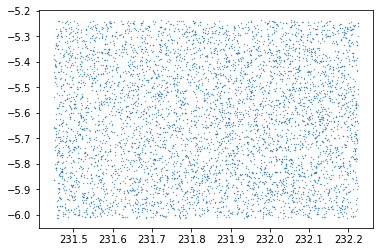

In [140]:
plt.scatter(cat2['ra'], cat2['dec'],s=0.1)

In [142]:
def radec_to_xy(wcs, ra, dec):
    """
    Convert ra/dec arrays to xy array
    Parameters
    ----------
    wcs : `lsst.afw.geom.SkyWcs`
       WCS object
    ra : `numpy.ndarray`
       Float array of RA positions
    dec : `numpy.ndarray`
       Float array of Dec positions
    Returns
    -------
    xy : `numpy.ndarray`
       2xN array of x/y positions associated with input ra/dec
    """
    xy = wcs.getTransform().getMapping().applyInverse(np.deg2rad(np.vstack((ra, dec))))
    return xy.T


xy = radec_to_xy(wcs, cat2['ra'].data, cat2['dec'].data)

In [150]:
xy

array([[-2389.91002226, -4888.60836515],
       [-2557.04874213, -4693.28252227],
       [-2594.34165042, -4651.55871465],
       ...,
       [ 8753.26827278,  8553.36444706],
       [ 8790.76890961,  8626.95220538],
       [ 8738.15185634,  8966.45835905]])

In [155]:
xs = xy[:,0]

In [158]:
ys = xy[:,1]

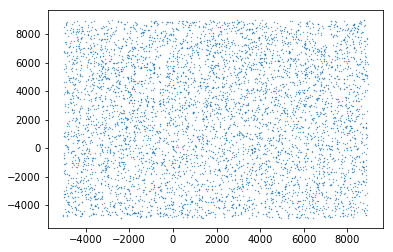

In [161]:
plt.scatter(xs,ys, s=0.1)

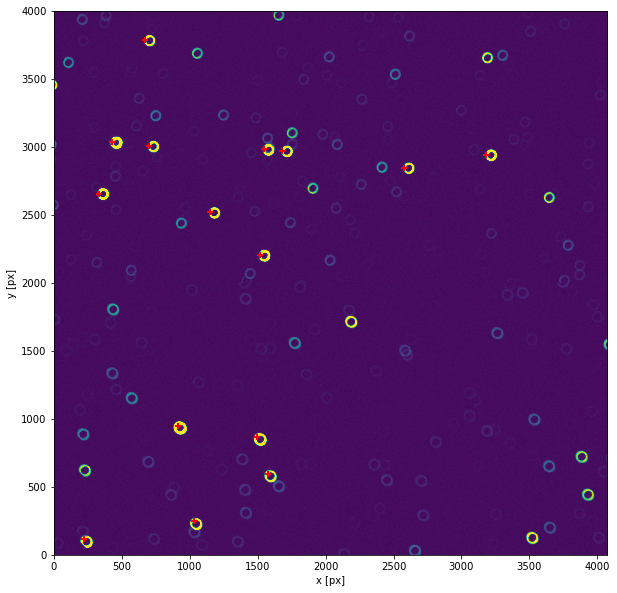

In [180]:
mcat = cat2['phot_g_mean_mag'] < 14
cat = cat2[mcat]

xy = radec_to_xy(wcs, cat['ra'].data, cat['dec'].data)
xs = xy[:,0]
ys = xy[:,1]

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(image, origin='lower', vmax=1200)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
mx = (0 < xs)*(xs<4000)
my = (0 < ys)*(ys<4000)
mxy = mx*my
args = {'marker':'+', 's':40,'edgecolor':'red', 
         'facecolor':'red', 'linewidth':2}
ax.scatter(xs[mxy],ys[mxy],**args)

In [ ]:
obj_pos_lsst = lsst.geom.SpherePoint(obj_pos.ra.deg, obj_pos.dec.deg, lsst.geom.degrees)


In [112]:
wcs.skyToPixel()

Docstring:
skyToPixel(*args, **kwargs)
Overloaded function.

1. skyToPixel(self: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, sky: lsst.geom.SpherePoint) -> lsst.geom.Point2D

2. skyToPixel(self: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, sky: List[lsst.geom.SpherePoint]) -> List[lsst.geom.Point2D]
Type:      method


In [95]:
from lsst.afw.geom import skyWcs

In [97]:
skyWcs = skyWcs


In [108]:
skyWcs.SkyWcs.skyToPixel(post.getWcs())

TypeError: skyToPixel(): incompatible function arguments. The following argument types are supported:
    1. (self: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, sky: lsst.geom.SpherePoint) -> lsst.geom.Point2D
    2. (self: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, sky: List[lsst.geom.SpherePoint]) -> List[lsst.geom.Point2D]

Invoked with: FITS standard SkyWcs:
Sky Origin: (233.017336, -4.447088)
Pixel Origin: (23190.5, 23180.5)
Pixel Scale: 0.2 arcsec/pixel

In [13]:
import numpy as np


In [17]:
np.save('neighborStarMap.npz', neighborStarMap,)

In [18]:
###
# below are parts of _calcWfErr() that we are testing : 
###
sensorNameList = list(neighborStarMap)
# detector_list = sensorNameList
isrImgMap = wep_calc.wepCntlr.getPostIsrImgMapOnCornerWfs(sensorNameList, obsIdList[0])

doDeblending = wep_calc.settingFile.getSetting("doDeblending")

postageImgDir = os.path.join(closed_loop_input_dir, 'postage')
if not os.path.exists(postageImgDir):
    os.makedirs(postageImgDir)



R:0,0 S:2,2,A is intra-focal
R:0,4 S:2,0,A is intra-focal
R:4,0 S:0,2,A is intra-focal
R:4,4 S:0,0,A is intra-focal
R:0,4 S:2,0,B is extra-focal
R:4,0 S:0,2,B is extra-focal


In [19]:
donutMap = wep_calc.wepCntlr.getDonutMap(neighborStarMap, isrImgMap, FilterType.REF,
                                         doDeblending=doDeblending, 
                                         postageImg=True,postageImgDir=postageImgDir)


 Calculating the donut map 
Saving postage stamp images in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt
Saving postage stamp image as intra_imgDeblend_resized_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt
Saving postage stamp image as intra_imgDeblend_resized_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt

Saving postage stamp as intra_singleSciImg_sensor-R00_S22_C0_star-2_id-14_posX-613_posY-3765.txt
Saving postage stamp image as intra_imgDeblend_full_sensor-R00_S22_C0_star-2_id-14_posX

Plot these postage stamps:

Using postage images from /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage
Searching in /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage directory

Available postage stamp images for sensor R00_S22: 

Looking for files that start with "intra_singleSciImg" and contain "R00_S22"...

Found 3 singleSciImg postage stamp images 
['intra_singleSciImg_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt', 'intra_singleSciImg_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-1402.txt', 'intra_singleSciImg_sensor-R00_S22_C0_star-2_id-14_posX-613_posY-3765.txt']

Looking for files that start with "intra_imgDeblend_full" and contain "R00_S22"...

Found 3 imgDeblend_full postage stamp images 
['intra_imgDeblend_full_sensor-R00_S22_C0_star-0_id-12_posX-824_posY-813.txt', 'intra_imgDeblend_full_sensor-R00_S22_C0_star-1_id-13_posX-740_posY-140

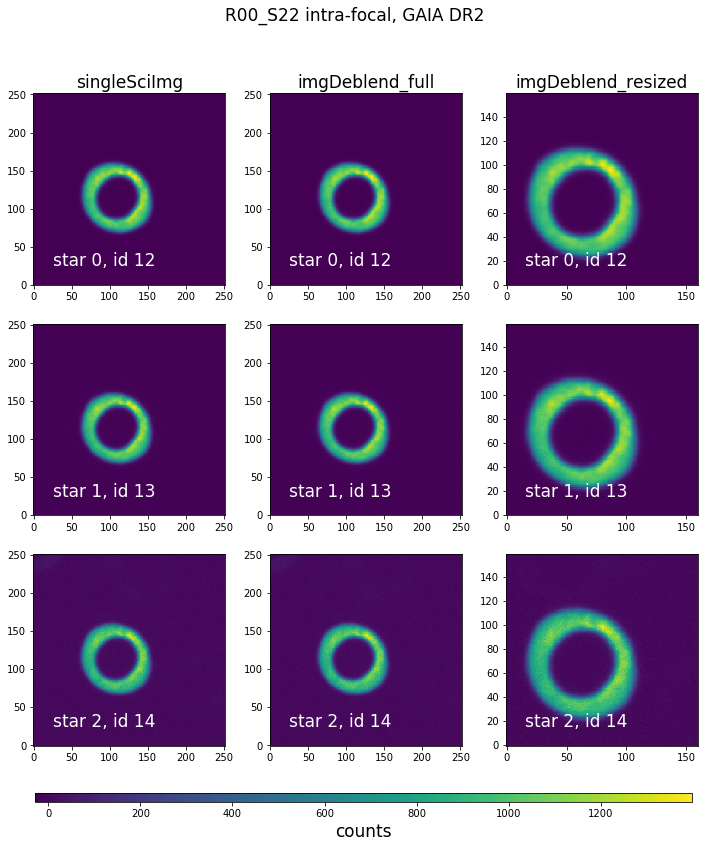

In [25]:
%matplotlib inline
import imp
imp.reload(at)
postage_dir= os.path.join(closed_loop_input_dir, 'postage')
at.plotPostageStamps(postage_dir, sensor='R00_S22', focalType='intra', Nstars=None,
                     testLabel='gaia')

Show the postISR image

In [22]:
data_dir = closed_loop_input_dir[:-len('/input')]
print(data_dir)
image = at.readPostISRImage(data_dir, focalType = 'intra', raft = 'R00', detector = 'S22',
                           rerun='run1')


/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done



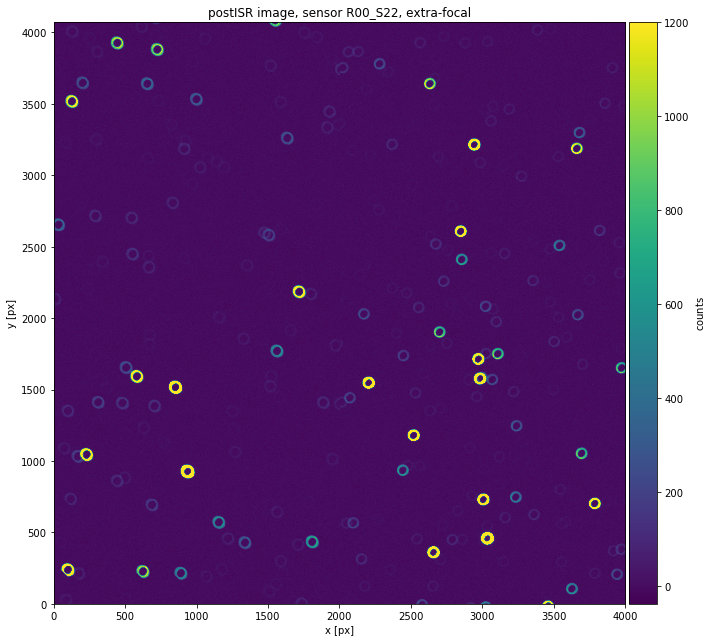

In [49]:
at.plotImage(image,ax=None, log=False, sensor='R00_S22', focalType='extra',
          postage=None,postFlag=False, centroid=False, 
          starMarker='redCross',starMarkerArgs=None,
          centMarkerArgs = None,centMarker='redCross', plotArgs = { 'vmax':1200})

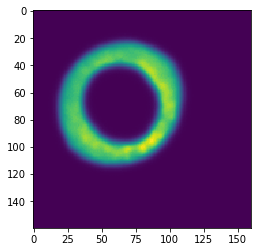

In [42]:
plt.imshow(donutMap['R:0,0 S:2,2,A'][0].getIntraImg())

In [43]:
postageImgDir

'/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/postage'

In [44]:
# now pass the donutMap to WepController to calculate wavefront error :
donutMap2 = wep_calc.wepCntlr.calcWfErr(donutMap,postageImgDir)




 Calculating the wavefront error based on the donut map


KeyError: 'R:0,0 S:2,2,B'

This fails because the code expects to find both intra and extra-focal donuts,  i.e.  `R:0,0 S:2,2,A`. and `R:0,0 S:2,2,B`... But it doesn't. So with `bscDbType : image`, not enough donuts are found at `_getTargetStar()` stage. 

## NEXT : 

In [ ]:
#
# TO DO : final steps 
#
wfs_zer_output = 'wfs.gaia.corner.txt'

listOfWfErr = wep_calc._populateListOfSensorWavefrontData(donutMap2)

zerDict = {}
for wfErrObj in listOfWfErr:
    zerDict[wfErrObj.getSensorId()] = wfErrObj.getAnnularZernikePoly()

sensorKeys = list(zerDict.keys())
sensorKeys.sort()

zerList = []
for sensorKey in sensorKeys:
    zerList.append(zerDict[sensorKey])
zerArray = np.array(zerList)

wfs_output_path = os.path.join(closed_loop_input_dir, wfs_zer_output)
np.savetxt(wfs_output_path, zerArray, header='The following are ZK in um from z4 to z22:')
print('WFS Zernike results saved as %s'%(wfs_output_path))

Show the Zernike errors : 

In [1]:
data_dir = closed_loop_input_dir[:-6]
opdZkFilePath = os.path.join(data_dir,  'iter0/img/opd.zer.gaia')
opdData = np.loadtxt(opdZkFilePath)


# new results, bscDbType: image, new ISR 
wfsZkFilePath1 = os.path.join(closed_loop_input_dir, 'wfs.gaia.corner.txt')
wfsData1 = np.loadtxt(wfsZkFilePath1)

### Plot all the corner wavefront sensors simulated with GAIA DR2 catalog: 

In [47]:
images = {}
for sensor in ['R00_S22', 'R40_S02', 'R44_S00', 'R04_S20']:
    raft = sensor[:3]
    detector = sensor[-3:]
    print(raft,detector)
    images[sensor] = at.readPostISRImage(data_dir, focalType = 'intra', 
                                         raft = raft, detector = detector,)


R00 S22
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R00', 'detectorName': 'S22', 'detector': 197}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R40 S02
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R40', 'detectorName': 'S02', 'detector': 209}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R44 S00
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R44', 'detectorName': 'S00', 'detector': 216}
Reading postISR images from the following repo_dir:
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_wideWFS/input/rerun/run1
Done

R04 S20
data_id is
{'visit': 9006002, 'filter': 'g', 'raftName': 'R04', 'detectorName

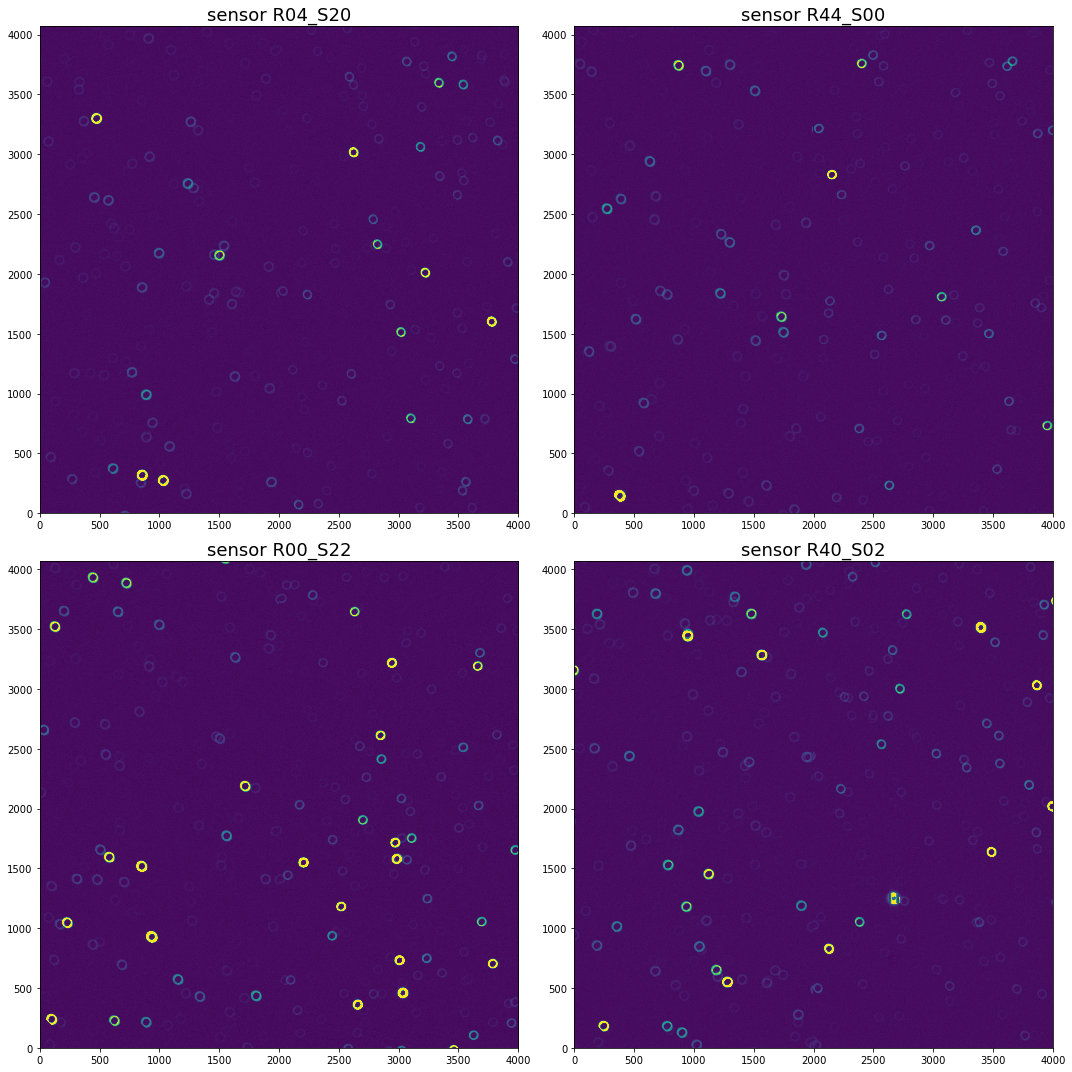

In [48]:
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,15))
ax = np.ravel(axs)

i = 0 
for sensor in ['R04_S20', 'R44_S00', 'R00_S22', 'R40_S02']:
    img = ax[i].imshow(images[sensor].T, origin='lower', vmax=1200)
    ax[i].set_title('sensor %s'%sensor, fontsize=18)
    i += 1 

plt.tight_layout()

plt.savefig('GAIA_DR2_med_corner_sensors.png', bbox_inches='tight')